# Classification of Pigmented Skin Lesions using lightweight SequeezeNet on depthwise Separable CNN

By using deep learning techniques and a publicly available dataset, *I am trying to classify nine classes of pigmnetd skein lesions **. 


The Skin Cancer ISIC dataset can be accessed on Kaggle through this [link](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic). There are in total 2357  images, split into various ratios of train, validation and test images. 
The ISIC dataset contains the following classes.
The data set contains the following diseases:

(1) actinic keratosis<br>
(2) basal cell carcinoma<br>
(3) dermatofibroma <br>
(4) Melanoma <br>
(5) Nevus<br>
(6) Pigmented benign keratosis <br>
(7) Seborrheic keratosis <br>
(8) Squamous cell carcinoma <br>
(9) Vascular lesion <br>
<br>





In [2]:
pip install silence_tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for silence-tensorflow: filename=silence_tensorflow-1.2.1-py3-none-any.whl size=4478 sha256=96f7884e636a9cc21b56fbfd95e7fd50c15d290412c42cc65c2bc7e418f44e18
  Stored in directory: /root/.cache/pip/wheels/4e/76/2e/dafd8a035c677744eca8d9c60a7dd539f7d694438da230148b
  Created wheel for support-developer: filename=support_developer-1.0.5-py3-none-any.whl size=5651 sha256=0ada7bd8bec032b4151533983054e98d60ce805d945fec9602bfc79d06c2ff55
  Stored in directory: /root/.cache/pip/wheels/e4/d3/9b/d4f296a0183daacaf202d8b69df27edca88326a47da66cd624
Successfully built silence-tensorflow support-developer


In [3]:
import os
import numpy as np
import pandas as pd
import time

from silence_tensorflow import silence_tensorflow
silence_tensorflow() # Silence INFO during model saving

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, SeparableConv2D
from tensorflow.keras import layers
from sklearn import metrics
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [9]:
# Mount Google Drive to access the data stored there
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a name="exploration"></a>

## Data processing and exploration

As with all other data related work we need to load and get to know the data before anything else. The images come in the size (224, 224) and I will keep them as is for now. If we run into problems with fitting the images in to the GPU memory we might consider decreasing the resolution. We should be careful when doing that though as we might lose important information. Decreasing the batch size, which I initially set to 32, can often be a safer alternative.

In [10]:
# Use the original image size and specify batch size and the data folders
image_size = (224, 224)
batch_size = 32
train_dir = '/content/drive/MyDrive/Dataset/ISIC/Train/'
test_dir = '/content/drive/MyDrive/Dataset/ISIC/Test/'

The data is stored in folders, one folder for the train set and one for the test set. Each one of those folders holds two other folders, one for each class - Malignant (1) and Benign (0). The validation set, used during training for checking the model performance to adjust the learning accordingly, will correspond to the last 20% of the data in the train folder. 

I will create data generators that will feed the model during training with data in batches. By using batch training virtually any size of dataset can be processed during training and will allow us to scale up if needed. The generators also takes care of scaling the images from their original `[0, 255]` to a more suitable `[0, 1]` range for neural networks. This will allow faster convergence, and thus training, while also improving performance. 

In [11]:
# ImageDataGenerator for the train and validation sets
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,       # Scaling the images to [0, 1]
    validation_split=0.2, # 20% of the data to be used for validation
)

# ImageDataGenerator for the test set
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# Train generator
train_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',  # With binary labels we later need to use binary_crossentropy loss.
    seed=34,             # Optional seed for loading the images in the same way in each run
    subset='training'     # Specifying that this generator is for training
)

# Validation generator
validation_generator = data_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    seed=34,
    subset='validation'   # Specifying that this generator is for validation
)

# Test data generator
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    #seed=5600,
)

Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


We can confirm that we are dealing with a small dataset. 2110 images for training, 527 for validation and 660 for testing. 

Do some quick sanity check on the three generators. We want the train data batches to have size `(32, 224, 224, 3)` while the labels should have size `(32,)`. 32 refers to the batch size, 224 and 224 to the image size and 3 to the image channel. Since we are working with color images there will be one dimension for each RGB color. 

In [12]:
# Train generator
for train_data_batch, train_label_batch in train_generator:
    print("Train data batch size:", train_data_batch.shape)
    print("Train label batch size:", train_label_batch.shape)
    break # We need to break the loop, else the generator would loop indefinitely

# Validation generator
for val_data_batch, val_label_batch in validation_generator:
    print("Validation data batch size:", val_data_batch.shape)
    print("Validation label batch size:", val_label_batch.shape)
    break

# Test generator
for test_data_batch, test_label_batch in test_generator:
    print("Test data batch size:", test_data_batch.shape)
    print("Test label batch size:", test_label_batch.shape)
    break

Train data batch size: (32, 224, 224, 3)
Train label batch size: (32,)
Validation data batch size: (32, 224, 224, 3)
Validation label batch size: (32,)
Test data batch size: (32, 224, 224, 3)
Test label batch size: (32,)


<br>

Next up, we will visualise some images by class to get a better understanding of what we are working with. These are all loaded from the train set. 

<br>

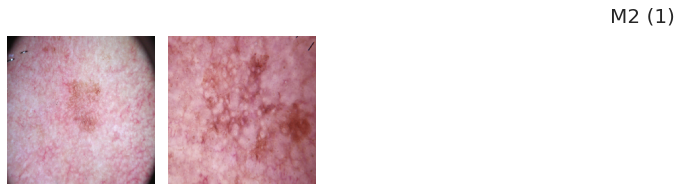

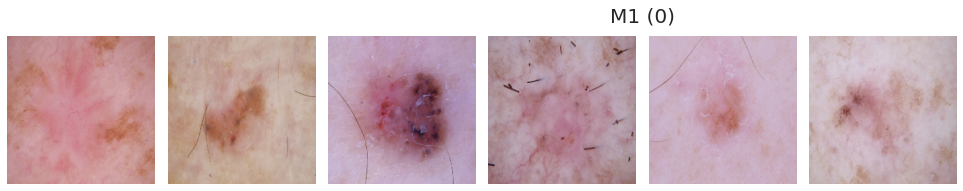

In [13]:
# Display images by their class
for images, labels in train_generator:
    # Select 9 classes of pigmented skin lesions separately
    malignant = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 1]
    benign = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 0]
    m1 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 0]
    m2 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 1]
    m3 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 2]
    m4 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 3]
    m5 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 4]
    m6 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 5]
    m7 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 6]
    m8 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 7]
    m9 = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 8]
      # Display images for malignant and benign tumors separately
    for image_label in [m1[:8], m2[:8]]:
        plt.figure(figsize=(18, 3))
        plt.suptitle('M1 (0)' if int(image_label[0]['label']) == 1 else 'M2 (1)', fontsize=20)

        for i in range(len(image_label)):
            plt.subplot(1, 8, i+1)
            plt.imshow(image_label[i]['image'])
            plt.axis('off')
        plt.tight_layout()
    break

The malignant tumors (1), on average, do seem to look slightly uglier than the benign tumors (0), with some few exceptions. But it's a very difficult task for an untrained eye to distinguish between the upper and lower row, and I wouldn't feel confident trying to classify these on my own. Luckily we have radiologists, and maybe soon also deep learning systems helping us out. 


Let's move forward with displaying the class distribution. 

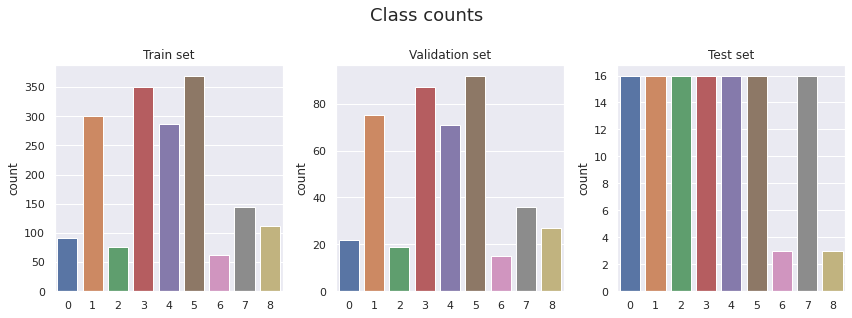

In [14]:
plt.figure(figsize=(12, 4))
plt.suptitle('Class counts', fontsize=18, y=1.1)

# Train set
plt.subplot(1, 3, 1)
sns.countplot(x=train_generator.classes)
plt.title('Train set')

# Validation set
plt.subplot(1, 3, 2)
sns.countplot(x=validation_generator.classes)
plt.title('Validation set')

# Test set
plt.subplot(1, 3, 3)
sns.countplot(x=test_generator.classes)
plt.title('Test set');

plt.tight_layout()
plt.show();

In [15]:
# Print out class distribution for the train, validation and test sets
for gen, name in zip([train_generator, validation_generator, test_generator], 
                     ['train', 'validation', 'test']):
    counts = np.bincount(gen.classes)
    tot = len(gen.classes)
    print(f"Class distribution in the {name} set")
    print(f"Class o: {counts[0]/tot:.0%}")
    print(f"Class 1: {counts[1]/tot:.0%}\n")
    print(f"Class 2: {counts[2]/tot:.0%}\n")
    print(f"Class 3: {counts[3]/tot:.0%}\n")
    print(f"Class 4: {counts[4]/tot:.0%}\n")
    print(f"Class 5: {counts[5]/tot:.0%}\n")
    print(f"Class 6: {counts[6]/tot:.0%}\n")
    print(f"Class 7: {counts[7]/tot:.0%}\n")
    print(f"Class 8: {counts[8]/tot:.0%}\n")

Class distribution in the train set
Class o: 5%
Class 1: 17%

Class 2: 4%

Class 3: 20%

Class 4: 16%

Class 5: 21%

Class 6: 3%

Class 7: 8%

Class 8: 6%

Class distribution in the validation set
Class o: 5%
Class 1: 17%

Class 2: 4%

Class 3: 20%

Class 4: 16%

Class 5: 21%

Class 6: 3%

Class 7: 8%

Class 8: 6%

Class distribution in the test set
Class o: 14%
Class 1: 14%

Class 2: 14%

Class 3: 14%

Class 4: 14%

Class 5: 14%

Class 6: 3%

Class 7: 14%

Class 8: 3%



The class distribution is equal in all three datasets and there is little class imbalance to speak of with 55% benign images and 45% malignant across all three. 

Next, define important metrics to keep track of during model training. We will hold recall as most important as it's worse to miss out on classifying a tumor as malignant than it is to accidentally classifying a benign as malignant. The former might lead to a patient's death while the latter, although very inconvenient, will only put the patient through more examinations. 


<a name="metrics"></a>


### Define metrics, callbacks and initial bias

In [16]:
# Define metrics
METRICS = [
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn')
]


# Calculate correct initial output bias for faster convergence
counts = np.bincount(train_generator.classes)
pos = counts[1]
neg = counts[0]

output_bias = -np.log(pos/neg)
print("Initial output bias:", output_bias)
output_bias = tf.keras.initializers.Constant(output_bias)

# Specify the correct initial input bias
input_bias = -np.log(1/2)
print("Initial input bias:", input_bias)
input_bias = tf.keras.initializers.Constant(input_bias)

Initial output bias: -1.1853216876998354
Initial input bias: 0.6931471805599453


<br>

Callbacks can be used for several things in Keras. In this case we will implement:

- `ModelCheckpoint`: Used for storing the best model when evaluated on the validation set during training. We only save the best model, overwriting old models if the new is better. 
- `EarlyStopping`: Deep learning model training takes time. This will cause training to stop if the validation AUC hasn't increased in 10 epochs.
- `CSVLogger`: Store the metrics after each epoch in a .csv file.

In [17]:
# Define a callbacks function
model_dir = '/content/drive/MyDrive/Dataset/ISIC/Models/'
csv_dir = '/content/drive/MyDrive/Dataset/ISIC/Logs/'


def callbacks(model_name, append_csv=False):
    """ Callbacks function for storing the best model, controlling early stopping
        and for storing the training and validation metrics in a csv file.
    
    Parameters
    ----------

    model_name: str
      Model name. The model will be stored under this name, excluding file extension.

    append_csv: Boolean
      False: overwrite existing file. True: append if file exists (useful for continuing training).
    
    """

    callb = [
             tf.keras.callbacks.ModelCheckpoint(
                 filepath=model_dir + model_name,
                 monitor='val_auc',
                 save_best_only=True,
                 mode='max'
             ),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_auc',
                 patience=10,                # Stop training if the val_auc hasn't improved after 10 epochs.
                 mode='max',
                 restore_best_weights=True, # Use the weights from the best model in each epoch
             ),
             tf.keras.callbacks.CSVLogger(
                 filename=csv_dir + model_name + '.csv',
                 separator=',',
                 append=append_csv,
             )
    ]
    return callb

<a name="baseline"></a>


# Baseline model


`SeparableConv2D` layers are used instead of the more common `Conv2D` layer since they are faster to train, require less memory while often yielding superior results. `MaxPooling2D` layers are used to downsample the feature map after each convolutional layer and is chosen over other pooling alternatives due to their proven superior performance. 

Since this is a binary classification problem, we add a fully connected classifier with a single output unit (`Dense` layer with 1 unit) and `sigmoid` activation function in the output layer. The general purpose with activation functions is to enable  mapping of non-linear relationships in the data. A `Relu` activation function will be used in the hidden layers as it normally yield faster convergence compared with other alternatives. We also initiate the output bias to better reflect the class imbalance in the dataset. That way the model doesn't have to spend time learning that during the first epochs. In this case though, the difference will be minimal as the classes are fairly well balanced. 

The number of `filters`, the `kerne_size`, `pool_size`, `Dropout` rate, the number of hidden layers and the way they are stacked are all hyper parameters than can be tuned for optimal performance. Researchers are spending their entire PhDs on building these architectures which are later released to the public. I simply don't have that time to spend on it so I will go with something simpler. Later, we will make use of some of these architectures through [Transfer Learning](#pre-trained_xception) though - a very common approach in the field. 



In [18]:
def make_base_model(dropout=0.0):
    """ Function for creating a simple baseline model. """
    input_tensor = keras.Input(shape=(None, None, 3), name='input')

    x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = SeparableConv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = SeparableConv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    if dropout:
        x = Dropout(rate=dropout)(x)

    x = Dense(16, activation='relu')(x)
    output = Dense(1, activation='sigmoid', name='output', 
                   bias_initializer=output_bias)(x) # Specify output bias

    model = keras.Model(inputs=input_tensor, outputs=output, name='base_model')
    return model

<a name="create_baseline"></a>


### Create the model


Create the baseline model using the previously defined `make_base_model()` function. Binary crossentropy is used as loss function since this is a binary problem and because the target labels are stored in a vector, as we saw before (rather than one-hot encoded). `Adam` optimizer with default `learning_rate` often works fine on problems like this. 


In [4]:
# Classes describing layers and models

class DWSLayer(nn.Module):
  def __init__(self, input_channels, output_channels, kernel_size, padding=0):
    super(DWSLayer, self).__init__()
    self.input_channels = input_channels
    self.output_channels = output_channels
    self.kernel_size = kernel_size
    self.padding = padding

    self.depthwise = nn.Conv2d(1, 1, self.kernel_size, padding=self.padding)
    self.pointwise = nn.Conv2d(input_channels, output_channels, 1)
    self.batchnorm = nn.BatchNorm2d(output_channels)


  def forward(self, x):
    # Depthwise convolution:
    out = self.depthwise(x[:,0].unsqueeze(1))
    for in_channel in range(1, len(x[0])):
      out = torch.cat((out, self.depthwise(x[:,in_channel].unsqueeze(1))), 1)

    # Pointwise convolution:
    out = self.pointwise(out)
    out = self.batchnorm(out)
    return out


class FireLayer(nn.Module):
  def __init__(self, input_channels, num_s11, num_e11, num_e33, DWS=False):
    super(FireLayer, self).__init__()
    self.input_channels = input_channels
    self.num_s11 = num_s11
    self.num_e11 = num_e11
    self.num_e33 = num_e33

    self.s11 = nn.Conv2d(input_channels, num_s11, 1)
    self.activ_f1 = nn.ReLU(inplace=True)
    self.e11 = nn.Conv2d(num_s11, num_e11, 1)
    self.e33 = nn.Conv2d(num_s11, num_e33, 3, padding=1)
    self.activ_f2 = nn.ReLU(inplace=True)

    if DWS:
      self.s11 = DWSLayer(input_channels, num_s11, 1)
      self.e11 = DWSLayer(num_s11, num_e11, 1)
      self.e33 = DWSLayer(num_s11, num_e33, 3, padding=1)


  def forward(self, x):
    # Squeeze
    x = self.s11(x)
    x = self.activ_f1(x)

    # Expand
    output_e11 = self.e11(x)
    output_e33 = self.e33(x)
    output = torch.cat((output_e11, output_e33), 1)
    output = self.activ_f2(output)
    return output


class SqueezeNet(nn.Module):
  def __init__(self, input_shape, n_classes, conv_layer_params, fire_layer_params, DWS=False):
    '''
    Args
    ----
    input_shape : HxWxD
    n_classes : Number of classes to predict from
    conv_layer_params : 2x2 array where clp[i] = [num_filters_i, kernel_size_i]
    fire_layer_params : 8x3 array where fls[i] = [s11_i, e11_i, e33_i]
    '''
    super(SqueezeNet, self).__init__()
    self.input_shape = input_shape
    self.n_classes = n_classes

    # For readability:
    clp = conv_layer_params.tolist()
    flp = fire_layer_params.tolist()
    flp2 = flp[0]
    flp3 = flp[1]
    flp4 = flp[2]
    flp5 = flp[3]
    flp6 = flp[4]
    flp7 = flp[5]
    flp8 = flp[6]
    flp9 = flp[7]

    self.conv1       = nn.Conv2d(input_shape[-1], clp[0][0], clp[0][1], padding=(int)((clp[0][1] - 1)/2))
    self.relu1       = nn.ReLU(inplace=True)
    self.fire_layers = nn.Sequential(
      FireLayer(        clp[0][0],  flp2[0], flp2[1], flp2[2], DWS),
      FireLayer(flp2[1] + flp2[2],  flp3[0], flp3[1], flp3[2], DWS),
      FireLayer(flp3[1] + flp3[2],  flp4[0], flp4[1], flp4[2], DWS),
      FireLayer(flp4[1] + flp4[2],  flp5[0], flp5[1], flp5[2], DWS),
      FireLayer(flp5[1] + flp5[2],  flp6[0], flp6[1], flp6[2], DWS),
      FireLayer(flp6[1] + flp6[2],  flp7[0], flp7[1], flp7[2], DWS),
      FireLayer(flp7[1] + flp7[2],  flp8[0], flp8[1], flp8[2], DWS),
      FireLayer(flp8[1] + flp8[2],  flp9[0], flp9[1], flp9[2], DWS)
    )
    self.conv10      = nn.Conv2d(flp9[1] + flp9[2], clp[1][0], clp[1][1], padding=(int)((clp[1][1] - 1)/2))
    self.relu2       = nn.ReLU(inplace=True)
    # Global Avg Pool
    self.avgpool2d   = nn.AvgPool2d(input_shape[0])
    # Softmax computed as part of CrossEntropy 
    self.linear      = nn.Linear(clp[1][0], self.n_classes)
    
    if DWS:
      self.conv1  = DWSLayer(  input_shape[-1], clp[0][0], clp[0][1], padding=(int)((clp[0][1] - 1)/2))
      self.conv10 = DWSLayer(flp9[1] + flp9[2], clp[1][0], clp[1][1], padding=(int)((clp[1][1] - 1)/2))

    
  def forward(self, x):
    x = self.conv1(x).to(device) # Convert to torch.cuda.FloatTensor
    x = self.fire_layers(x)
    x = self.conv10(x)
    x = self.avgpool2d(x)
    x = torch.flatten(x, start_dim=1, end_dim=-1)
    x = self.linear(x)
    return x


def build_squeezenet(conv_layer_params, fire_layer_params, input_shape=(28, 28, 1), n_classes=10):
  model = SqueezeNet(input_shape, n_classes, conv_layer_params, fire_layer_params)
  return model

def build_squeezenet_depthwise(conv_layer_params, fire_layer_params, input_shape=(28, 28, 1), n_classes=10):
  model = SqueezeNet(input_shape, n_classes, conv_layer_params, fire_layer_params, DWS=True)
  return model

In [5]:
# Default layer architectures from Figure2 of the SqueezeNet paper:
conv_layer_params = np.asarray([[  96, 7],
                                [1000, 1]])
fire_layer_params = np.asarray([[16,  64,  64],
                                [16,  64,  64],
                                [32, 128, 128],
                                [32, 128, 128],
                                [48, 192, 192],
                                [48, 192, 192],
                                [64, 256, 256],
                                [64, 256, 256]])

# Demonstrating model size comparison:
model = build_squeezenet(conv_layer_params, fire_layer_params)
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)
print(model)

model_dw = build_squeezenet_depthwise(conv_layer_params, fire_layer_params)
pytorch_total_params = sum(p.numel() for p in model_dw.parameters())
print(pytorch_total_params)
print(model_dw)

1249026
SqueezeNet(
  (conv1): Conv2d(1, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU(inplace=True)
  (fire_layers): Sequential(
    (0): FireLayer(
      (s11): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (activ_f1): ReLU(inplace=True)
      (e11): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (e33): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activ_f2): ReLU(inplace=True)
    )
    (1): FireLayer(
      (s11): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (activ_f1): ReLU(inplace=True)
      (e11): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (e33): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activ_f2): ReLU(inplace=True)
    )
    (2): FireLayer(
      (s11): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
      (activ_f1): ReLU(inplace=True)
      (e11): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (e33): Conv2d(32, 128, kernel_size=(3, 3), 

In [6]:
# training the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print("Cuda Available")
  model.to(device)
  model_dw.to(device)

Cuda Available


In [ ]:
def train_model(DWS, conv_layer_params, fire_layer_params, learning_rates, batch_sizes, root):
  # Initialization before loops:
  train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=2, shuffle=True,  num_workers=2)
  test_data_loader  = torch.utils.data.DataLoader(test_data,  batch_size=2, shuffle=False, num_workers=2)
  model = build_squeezenet(conv_layer_params, fire_layer_params)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

  tr_loss_history = []
  tr_acc_history = []

  for batch_size in batch_sizes:
    num_batches = int(6000/batch_size)
    num_checks = 10
    batches_per_check = int(num_batches/num_checks)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)
    test_data_loader  = torch.utils.data.DataLoader(test_data,  batch_size=batch_size, shuffle=False, num_workers=2)

    early_stop_thresh = 0.001
    patience = int(num_checks / 3)

    for lr in learning_rates:
      stop_flag_idx = -1
      print('Learning Rate: ' + str(lr) + '; Batch Size: ' + str(batch_size))
      
      model = build_squeezenet(conv_layer_params, fire_layer_params)
      if DWS:
        model = build_squeezenet_depthwise(conv_layer_params, fire_layer_params)

      if torch.cuda.is_available():
        print("Cuda Available")
        model.to(device)

      optimizer = Adam(model.parameters(), lr = lr)
      criterion = nn.CrossEntropyLoss()
      curr_loss_history = []    

      for epoch in range(3):
        running_loss = 0.0
        for mini_batch, d in enumerate(train_data_loader, 0):
          # print(mini_batch)
          inputs, class_labels = d
          if torch.cuda.is_available():
            inputs, class_labels = d[0].to(device), d[1].to(device)

          optimizer.zero_grad()
          train_output = model(inputs)
          batch_loss = criterion(train_output.squeeze(), class_labels)
          batch_loss.backward()
          optimizer.step()

          # Print loss
          running_loss += batch_loss.item()
          if mini_batch % batches_per_check == batches_per_check - 1:
              print('Epoch: %d, Batch_idx: %5d Loss: %.3f' %
                    (epoch + 1, mini_batch + 1, running_loss / batches_per_check))
              curr_loss_history.append(running_loss)

              # Early stopping:
              if len(curr_loss_history) > 3:
                if stop_flag_idx == -1:
                  if abs(running_loss - curr_loss_history[-2]) < early_stop_thresh:
                    stop_flag_idx = len(curr_loss_history) - 1
                  # Else continue
                else:
                  if abs(running_loss - curr_loss_history[stop_flag_idx]) < early_stop_thresh:
                    if (len(curr_loss_history) - 1 - stop_flag_idx) > patience:
                      print("Early stopping: Curr Batch Loss = " + str(running_loss) + 
                                          ", Prev Batch Loss = " + str(curr_loss_history[-2]) + 
                                                ", Patience = " + str(patience))
                      print("Ended on batch: " + str(len(curr_loss_history)))
                      stop_flag_idx = -1
                      break
              running_loss = 0.0

      print('Finished Training')
      tr_loss_history.append(curr_loss_history)
      
      # Final accuracy after training:
      correct = 0.0
      total = 0.0
      with torch.no_grad():
          for data in test_data_loader:
              images, labels = data
              if torch.cuda.is_available():
                images, class_labels = data[0].to(device), data[1].to(device)
              outputs = model(images)
              _, predicted = torch.max(outputs.squeeze().data, 1)
              total += labels.size(0)
              labels = labels.to(device)
              correct += (predicted == labels).sum().item()

      print('Accuracy of the network on the 10000 test images: %d %%' % (
          100 * correct / total))
      tr_acc_history.append(float(correct / total))

      # Save model parameters:
      PATH =   root +     'model_lr' + str(lr) + '_batchsize_' + str(batch_size) + '_acc_' + str(100.0*correct/total)
      if DWS:
        PATH = root + 'DWS_model_lr' + str(lr) + '_batchsize_' + str(batch_size) + '_acc_' + str(100.0*correct/total)
      torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': batch_loss
              }, PATH)

In [ ]:
# Ran for 15 Epochs
train_model(True, conv_layer_params, fire_layer_params, [0.01], [100], root)

In [19]:
# Create new model and compile it
model = make_base_model()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=METRICS)
model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 separable_conv2d (Separable  (None, None, None, 32)   155       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, None, None, 64)   2400      
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 64)   0         
 2D)                                                    

<br>

The resulting architecture has a total of 49,756 parameters - all trainable. 


<a name="train_baseline"></a>


### Train the model


Train the model for 50 epochs and keep track of the resulting metrics on the train and validation sets. Store those in a variable called `history`. Note that because we implemented callbacks the model will stop training prior to 50 epochs if the validation AUC hasn't increased over 10 consecutive epochs. 

In [20]:
%%time

# Train the model
history = model.fit(train_generator,
                    epochs=1,
                    callbacks=callbacks('base_model'),
                    validation_data=validation_generator,
                    workers=2,
                    )

57/57 [==============================] - ETA: 0s - loss: 0.0000e+00 - recall: 0.4668 - auc: 0.5024 - precision: 0.9521 - accuracy: 0.0992 - tp: 795.0000 - fp: 40.0000 - tn: 52.0000 - fn: 908.0000

57/57 [==============================] - 323s 5s/step - loss: 0.0000e+00 - recall: 0.4668 - auc: 0.5024 - precision: 0.9521 - accuracy: 0.0992 - tp: 795.0000 - fp: 40.0000 - tn: 52.0000 - fn: 908.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000 - val_auc: 0.5000 - val_precision: 0.9505 - val_accuracy: 0.1689 - val_tp: 422.0000 - val_fp: 22.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00
CPU times: user 57.2 s, sys: 3.31 s, total: 1min
Wall time: 5min 24s


In [27]:
#Model Proposed Compile
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy', 'categorical_crossentropy'])
model.summary()

TypeError: ignored

In [ ]:
def smooth(points, factor=0.8):
    """ Function for smoothing out metric curves. """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot_history(hist_dict, soft=False):
    """ Function for plotting Loss, Accuracy, AUC and Recall. 
        Possibility of smoothing out the curves by setting soft=True. 
    """

    epochs = range(1, len(hist_dict['accuracy']) + 1)

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, smooth(hist_dict['loss']) if soft else hist_dict['loss'], 
             'bo', label='Train loss')
    plt.plot(epochs, smooth(hist_dict['val_loss']) if soft else hist_dict['val_loss'], 
             'b', label='Val loss')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(epochs, smooth(hist_dict['accuracy']) if soft else hist_dict['accuracy'], 
             'bo', label='Train accuracy')
    plt.plot(epochs, smooth(hist_dict['val_accuracy']) if soft else hist_dict['val_accuracy'], 
             'b', label='Val accuracy')
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(epochs, smooth(hist_dict['auc']) if soft else hist_dict['auc'], 
             'bo', label='Train AUC') 
    plt.plot(epochs, smooth(hist_dict['val_auc']) if soft else hist_dict['val_auc'], 
             'b', label='Val AUC')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(epochs, smooth(hist_dict['recall']) if soft else hist_dict['recall'], 
             'bo', label='Train recall') 
    plt.plot(epochs, smooth(hist_dict['val_recall']) if soft else hist_dict['val_recall'], 
             'b', label='Val recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_cm(labels, predictions):
    """ Function for plotting the confusion matrix and corresponding metrics. """
    cm = tf.math.confusion_matrix(labels=labels,
                                  predictions=predictions)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, cbar=False, fmt='d')
    plt.title('Confusion Matrix @0.50')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show();

    print("\nMalignant Tumors Detected          (True Positives):", cm[1][1].numpy())
    print("Malignant Tumors Missed            (False Negatives):", cm[1][0].numpy())
    print("Benign Tumors Detected             (True Negatives):", cm[0][0].numpy())
    print("Benign Tumors Incorrectly Detected (False Positives):", cm[0][1].numpy())


def get_predictions_and_labels(model, generator):
    """ Function for making predictions and extracting corresponding labels """
    predictions = []
    labels = []
    n = len(generator.labels)
    for d, l in generator:
        predictions.extend(model.predict(d).flatten())
        labels.extend(l)
        if (len(l) < generator.batch_size) and (len(predictions) >= n):
            return np.array(predictions), np.array(labels)


def plot_roc(name, labels, predictions, **kwargs):
    """ Function for plotting the ROC curve. """
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5, 60])
    plt.ylim([20, 100.5])
    plt.grid(True)
    plt.title('ROC', fontsize=16)
    plt.legend(loc='lower right');


def plot_prc(name, labels, predictions, **kwargs):
    """ Function for plotting the area under the interpolated precision-recall curve (AUPRC). """
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.title('AUPRC', fontsize=16);

<a name="baseline_history"></a>

### Check training history

Plot the Loss, Accuracy, AUC and Recall for both the train and validation sets during training. 

In [ ]:
# Plot loss, accuracy, AUC and recall on the train and validation sets
plot_history(history.history)

NameError: ignored

The first thing to note is how irregular the validation curves are with their zig-zag shape. We also note the *high bias* - in particular on accuracy - which is likely a result of the small model that is not able to learn the characteristics of the data properly. *Variance is low* with only minor differences between the train and validation curves across all metrics. 

It turns out to be quite difficult to smooth out these "hockey stick" curves. Experimenting with lower learning rates for `Adam` optimizer, trying `RMSprop` optimizer as well as smaller and larger networks (2 to 5 hidden layers, and increasing filter size; 32 to 512 filters) all yield pretty much the same curve characteristics. Ideally, we would use something like [Keras Tuner](https://keras-team.github.io/keras-tuner/) to properly build and evaluate an architecture like this. But as this is a very resource intensive process I will put it off for future work when using a more powerful GPU. 


<a name="evaluate_baseline"></a>


### Evaluate metrics

Evaluate the best model on the test set. Remember that we stored only the best model during training, so we will use that. We will also plot a confusion matrix to better understand the model's strenghts and weaknesses. The prediction threshold is set to 50%, meaning that the model needs to be at least 50% confident in order to classify a sample as malignant. 


In [ ]:
# Load and evaluate the best model on the test set
base_model = keras.models.load_model(model_dir+'base_model')
test_results = base_model.evaluate(test_generator)

4/4 [==============================] - 71s 23s/step - loss: 0.0000e+00 - recall: 1.0000 - auc: 0.5000 - precision: 0.8644 - accuracy: 0.1356 - tp: 102.0000 - fp: 16.0000 - tn: 0.0000e+00 - fn: 0.0000e+00


1/1 [==============================] - 0s 25ms/step


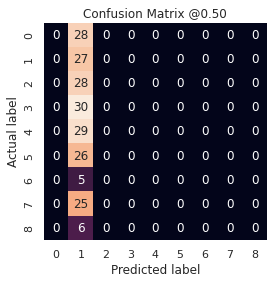


Malignant Tumors Detected          (True Positives): 27
Malignant Tumors Missed            (False Negatives): 0
Benign Tumors Detected             (True Negatives): 0
Benign Tumors Incorrectly Detected (False Positives): 28


In [ ]:
# Make predictions, extract corresponding labels and plot confusion matrix
test_preds_baseline, test_labels = get_predictions_and_labels(base_model, test_generator)
plot_cm(test_labels, test_preds_baseline>0.5)

<br>

The model correctly classifies 295 malignant and 230 benign tumors. And it only misses out on 5 malignant tumors. So far so good. However, if we take a look at the number of benign tumors falsely being classified as malignant we see a serious problem. It seems that whenever the model is unsure of what class a sample belongs to it classifies it as malignant. Better safe than sorry one might think! But with 130 harmless tumors incorrectly classified as malignant many patients will face unnecessary worries and examinations. Clearly we can do better. 


<a name="roc_auprc"></a>

### Plot the ROC and AUPRC

Before moving on though, let's plot the *Receiver Operating Characteristic* (ROC) and *Area Under the interpolated Precision-Recall Curve* (AUPRC). The curves are very useful as they display in a clear way the trade-off between true positives and false positives (as in the ROC) and precision and recall (as in the AUPRC); as one metric increase, the other one decreases. It's a common problem machine learning engineers and data scientists face. 


In [ ]:
# Get predictions and labels for the train and validation sets
train_preds_baseline, train_labels_baseline = get_predictions_and_labels(base_model, train_generator)
validation_preds_baseline, validation_labels_baseline = get_predictions_and_labels(base_model, validation_generator)

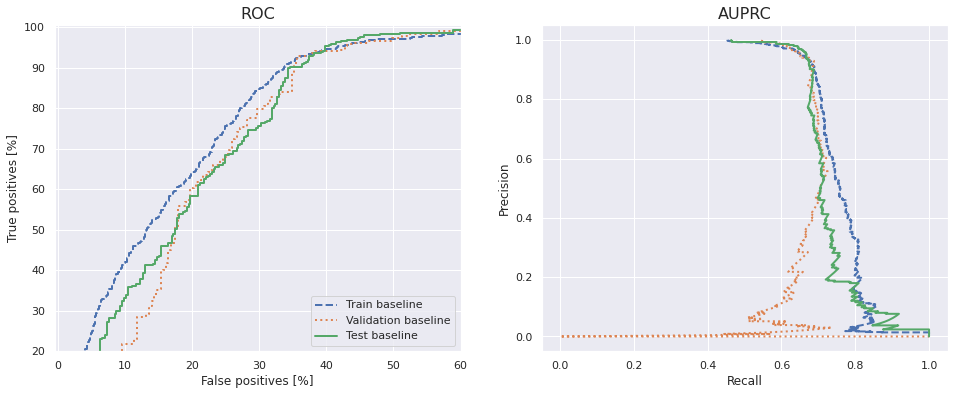

In [ ]:
# Plot the ROC and AUPRC
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train baseline', train_labels_baseline, train_preds_baseline, linestyle='--')
plot_roc('Validation baseline', validation_labels_baseline, validation_preds_baseline, linestyle=':')
plot_roc('Test baseline', test_labels, test_preds_baseline);

plt.subplot(1, 2, 2)
plot_prc('Train baseline', train_labels_baseline, train_preds_baseline, linestyle='--')
plot_prc('Validation baseline', validation_labels_baseline, validation_preds_baseline, linestyle=':')
plot_prc('Test baseline', test_labels, test_preds_baseline)

Ideally, the ROC should be as close up to the top left corner as possible while the AUPRC as high up to the right as possible. We can see that there's definitely room for improvement in both cases. The model is learning something though, and that's encouraging for coming steps. 



<a name="multiple_baselines"></a>


### Train and evaluate multiple baseline models

Due to randomness on both the system and TensorFlow level the results differ between each run (a run is here referred to building, training and evaluating a model). To get a better estimaton of the model's performance, build, train and evaluate 10 models and average their results. Ideally, we would run even more models, but that would take very long time, and I will thus leave it for future work. 

Start by defining a function that does all that for us and outputs the scores on the train, validation and test sets. 

In [ ]:
def train_and_evaluate_model_n_times(n_times, train_gen, valid_gen, test_gen, 
                                     name, dropout=0.0, epochs=20):
    """ Function for training and evaluating a model over several runs for a better 
        estimaton of the performance. Returns scores on the test, validation and test sets. 

    Parameters
    ----------

    n_times: int
      Number of models to train and evaluate. Higher values takes longer but yield 
      more confident estimations.

    train_gen: generator, Numpy array, DataFrame
      Train set.

    valid_gen: generator, Numpy array, DataFrame
      Validation set.

    test_gen: generator, Numpy array, DataFrame
      Test set.

    name: str
      Name to store models and scores under.

    dropout: float
      Float between 0 and 1 specifying the fraction of input units to drop.

    epochs: int
      Number of epochs to train each model for. 

    """
    histories = []                # Train and validation scores
    test_scores = []              # Test scores

    for i in range(n_times):
        print(f"Training model: {i+1} (out of {n_times} times)...")
        start = time.time()

        # Instantiate a new model
        model = make_base_model(dropout)
        # Compile the model
        model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(),
                      metrics=METRICS)
        # Train it
        hist = model.fit(train_gen,
                         epochs=epochs,
                         callbacks=callbacks(name),
                         validation_data=valid_gen,
                         workers=2,
                         verbose=0,
                  )
        
        # Print out how long it took to train one model
        time_taken = time.gmtime(int(time.time() - start))
        print(f'Time taken: {time.strftime("%Hh %Mmin %Ss", time_taken)} ... Evaluating...')

        # Load the best model and evaluate it on the test set
        best_model = keras.models.load_model(model_dir+name)
        test_score = best_model.evaluate(test_gen, return_dict=True)
        
        # Store the results
        histories.append(hist.history)
        test_scores.append(test_score)

        # Clear memory by releasing the global state
        tf.keras.backend.clear_session()

    # Save histories and test scores to file
    pd.DataFrame(histories).to_csv(csv_dir+name+'_histories.csv', index=False)
    pd.DataFrame(test_scores).to_csv(csv_dir+name+'_scores.csv', index=False)

    return histories, test_scores


def print_model_performance(scores, dset='test'):
    print(f"Average model performance on the {dset} set over {scores.shape[0]} runs:\n")
    for col in scores:
        mean = np.mean(scores[col])
        std = np.std(scores[col])
        print("{:<10} {:<5} (±{:.2f})".format(str(col+':').capitalize(), np.round(mean, 2), std))

Build, train and evaluate 10 models over 20 epochs each.

In [ ]:
%%time

# Train and evaluate 10 models
histories, test_scores = train_and_evaluate_model_n_times(4,
                                                          train_generator, 
                                                          validation_generator, 
                                                          test_generator,
                                                          name='base_model_cv')

Training model: 1 (out of 4 times)...
Time taken: 00h 04min 53s ... Evaluating...
21/21 [==============================] - 3s 125ms/step - loss: 0.3863 - recall: 0.9067 - auc: 0.8967 - precision: 0.7139 - accuracy: 0.7924 - tp: 272.0000 - fp: 109.0000 - tn: 251.0000 - fn: 28.0000
Training model: 2 (out of 4 times)...
Time taken: 00h 04min 43s ... Evaluating...
21/21 [==============================] - 3s 118ms/step - loss: 0.3877 - recall: 0.9700 - auc: 0.8954 - precision: 0.6995 - accuracy: 0.7970 - tp: 291.0000 - fp: 125.0000 - tn: 235.0000 - fn: 9.0000
Training model: 3 (out of 4 times)...
Time taken: 00h 04min 49s ... Evaluating...
21/21 [==============================] - 3s 119ms/step - loss: 0.3685 - recall: 0.8867 - auc: 0.9114 - precision: 0.7801 - accuracy: 0.8348 - tp: 266.0000 - fp: 75.0000 - tn: 285.0000 - fn: 34.0000
Training model: 4 (out of 4 times)...
Time taken: 00h 04min 52s ... Evaluating...
21/21 [==============================] - 4s 118ms/step - loss: 0.5054 - recal

<a name="baseline_metrics_multiple"></a>


### Evaluate metrics over multiple runs

The results with standard deviations over 10 runs are displayed below. There are fairly large discrepancies between the lowest and highest values across all metrics (check the standard deviations within the parentheses). However, we can also see that already this fairly simple baseline model performs well with a Recall of 92%, AUC of 86% and Accuracy of 76%. Just as we pointed out before though, the precision is lower at 70% since the model has a tendency of always predicting malignant when it's unsure.

In [ ]:
print_model_performance(pd.DataFrame(test_scores))

Average model performance on the test set over 4 runs:

Loss:      0.41  (±0.05)
Recall:    0.94  (±0.04)
Auc:       0.89  (±0.02)
Precision: 0.7   (±0.06)
Accuracy:  0.79  (±0.04)
Tp:        281.5 (±12.85)
Fp:        122.75 (±38.68)
Tn:        237.25 (±38.68)
Fn:        18.5  (±12.85)


<br>

<a name="augmentation"></a>


# Data augmentation

A common way of improving the performance of a model is to add more data. If that's not possible, then rotating, zooming, flipping, adjusting brightness and so fort on the data you already have, can often be a good and simple way of improving model performance. This is easily done in `Keras` using the `ImageDataGenerator` we used before. There are two large advantages of augmenting during data loading; we can take advantage of the parallel threads in the GPU, allowing faster processing as well as it makes the final production-ready model more robust by allowing it to take in any kind of raw images. That way we won't have to worry about correctly pre-processing the images in a parallel process as everything is taken care of by the model architecture. 


In [ ]:
# Create folders for inspecting the augmented images
augmented_dir = '/content/drive/MyDrive/Deep_Learning/Skin-cancer/data/Augmented_example_images/'
train_inspection_dir = augmented_dir + 'train_inspection'
validation_inspection_dir = augmented_dir + 'validation_inspection'

try:
    os.makedirs(train_inspection_dir)
    os.makedirs(validation_inspection_dir)
except FileExistsError:
    pass

<a name="augmented_generators"></a>


### Define data generators with augmentation

Rotation range is used to randomly rotate the images ±30 degrees while `fill_mode='constant'` fills out the discrepancy between the original and augmented image area with a constant value (black, or 0, in this case). Knowing that, the rest of the parameters are fairly self-explanatory. 

Exactly how these parameters are set is something that can and should be experimented with for optimal model perfomance. Remember that with a larger specified range more new images will be created and the more time and processing power is needed to train the model. The advantage is that we can potentially get better results. Again, this is a common trade-off we often have to make. 

The `save_to_dir` parameter for the train and validation generators are used to store the images processed by the generator. This is very useful for inspecting exactly what images are being fed into the model and can save us from a lot of headache if the model doesn't behave as expected. After repeated experimentation I have commented out these to save disk space. 

In [ ]:
# Data generator WITH data augmentation for the train set
train_gen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.9, 1.1],
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='constant',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.2, # 20% of the data to be used for validation
)

# Data generator WITHOUT data augmentation for the validation set
valid_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

# Data generator WITHOUT data augmentation for the test set
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# Train generator
train_generator_augmentation = train_gen_aug.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary', # with binary labels we later need to use binary_crossentropy loss.
    #seed=34,
    #save_to_dir=train_inspection_dir,
    subset='training'
)

# Validation generator
validation_generator = valid_gen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    #seed=34,
    #save_to_dir=validation_inspection_dir,
    subset='validation'
)

# Test data generator
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    #seed=5600,
)

Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


<a name="visualise_aug_images"></a>


### Visualise augmented images

Visualise some of the augmented images.

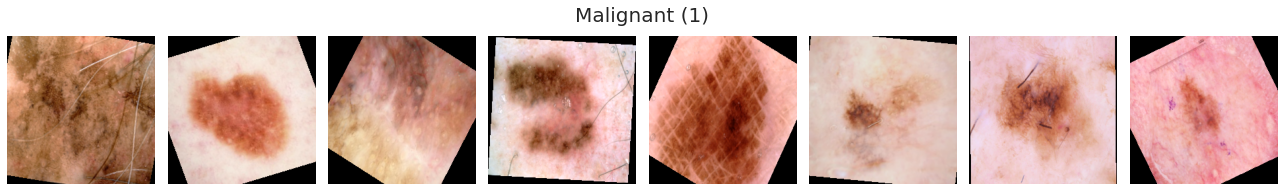

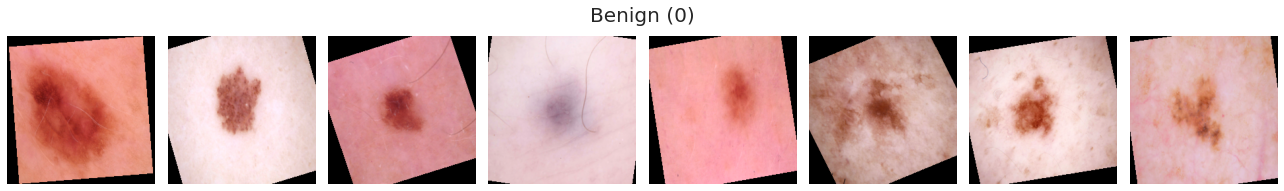

In [ ]:
# Display images by their class
for images, labels in train_generator_augmentation:
    # Select malignant and benign tumors separately
    malignant = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 1]
    benign = [{'image': image, 'label': label} for image, label in zip(images, labels) if label == 0]
    
    # Display images for malignant and benign tumors separately
    for image_label in [malignant[:8], benign[:8]]:
        plt.figure(figsize=(18, 3))
        plt.suptitle('Malignant (1)' if int(image_label[0]['label']) == 1 else 'Benign (0)', fontsize=20)

        for i in range(len(image_label)):
            plt.subplot(1, 8, i+1)
            plt.imshow(image_label[i]['image'])
            plt.axis('off')
        plt.tight_layout()
    break

We note the black areas around the augmented images as well as rotations, zooming and in some cases also differences in brightness. Great! This normally allows a model to better learn the difference between classes, in this case between malignant and benign tumors, as it has more variations of each image to learn from. 


<a name="train_aug_model"></a>


### Train the model


Here I am also choosing to add 50% dropout after the convolutional layers. This means that 50% of the input units are randomly dropped during training. It forces the model to learn the more important characteristics of the data and is a way to further regularise the model to prevent overfitting. It often leads to improvements on the validation and test sets. The dropout layer is only activated during training. 

In [ ]:
%%time 

# Use the same model architecture as before
model = make_base_model(dropout=0.5)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=METRICS)

# Train the model
history = model.fit(train_generator_augmentation,
                    epochs=10,
                    callbacks=callbacks('base_model_augmented'),
                    validation_data=validation_generator,
                    workers=2)

Epoch 1/10
66/66 [==============================] - 40s 562ms/step - loss: 0.6939 - recall: 0.4369 - auc: 0.5983 - precision: 0.5235 - accuracy: 0.5639 - tp: 523.0000 - fp: 476.0000 - tn: 964.0000 - fn: 674.0000 - val_loss: 0.6892 - val_recall: 0.0000e+00 - val_auc: 0.6777 - val_precision: 0.0000e+00 - val_accuracy: 0.5465 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 288.0000 - val_fn: 239.0000
Epoch 2/10
66/66 [==============================] - 33s 491ms/step - loss: 0.6847 - recall: 0.0031 - auc: 0.5630 - precision: 0.7500 - accuracy: 0.5469 - tp: 3.0000 - fp: 1.0000 - tn: 1151.0000 - fn: 955.0000 - val_loss: 0.6571 - val_recall: 0.0084 - val_auc: 0.7543 - val_precision: 0.6667 - val_accuracy: 0.5484 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 287.0000 - val_fn: 237.0000
Epoch 3/10
66/66 [==============================] - 33s 496ms/step - loss: 0.5928 - recall: 0.6420 - auc: 0.7414 - precision: 0.6571 - accuracy: 0.6853 - tp: 615.0000 - fp: 321.0000 - tn: 831.0000 - fn: 343.00

<br>

We note that after 38 epochs the validation AUC has stopped improving and the model terminates training. 


<a name="check_aug_history"></a>


### Check training history


I have chosen to slightly smoothen out the curves this time.

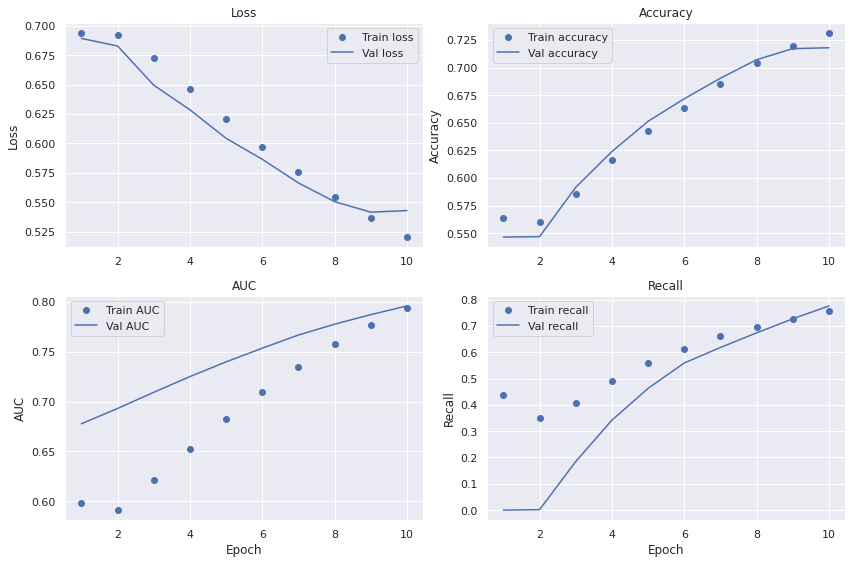

In [ ]:
# Plot loss, accuracy, AUC and recall on the train and validation sets
plot_history(history.history, soft=True)

All in all there seem to be little difference between the baseline model. Quite disappointing. However, the dataset is small and there is a lot of randomness in the process. Let's dive a little deeper. 


<a name="evaluate_aug_metrics"></a>


### Evaluate metrics

In [ ]:
# Load the best model and evaluate it on the test set
augm_model = keras.models.load_model(model_dir+'base_model_augmented') # Load the best augmented model
test_results = augm_model.evaluate(test_generator)

21/21 [==============================] - 3s 119ms/step - loss: 0.5301 - recall: 0.9967 - auc: 0.8755 - precision: 0.6308 - accuracy: 0.7333 - tp: 299.0000 - fp: 175.0000 - tn: 185.0000 - fn: 1.0000


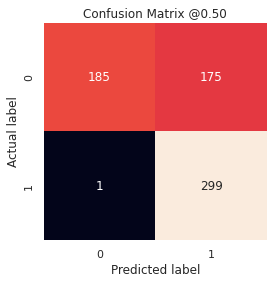


Malignant Tumors Detected          (True Positives): 299
Malignant Tumors Missed            (False Negatives): 1
Benign Tumors Detected             (True Negatives): 185
Benign Tumors Incorrectly Detected (False Positives): 175


In [ ]:
# Make predictions, extract labels and plot confusion matrix
test_preds_augmented, test_labels = get_predictions_and_labels(augm_model, test_generator)
plot_cm(test_labels, test_preds_augmented>0.5)

<br>

The metrics on the test set are all fairly comparable as well and could certaintly be explained by randomness alone. 


<a name="roc_auprc_aug"></a>


### Plot the ROC and AUPRC

In [ ]:
# Get predictions and labels for the train and validation sets
train_preds_augmented, train_labels_aug = get_predictions_and_labels(augm_model, train_generator_augmentation)
validation_preds_augmented, validation_labels_aug = get_predictions_and_labels(augm_model, validation_generator)

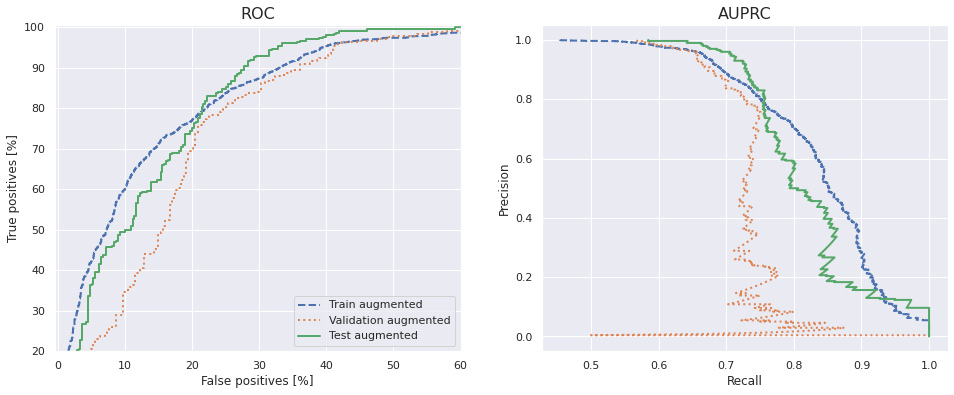

In [ ]:
# Plot the ROC and AUPRC
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train augmented', train_labels_aug, train_preds_augmented, linestyle='--')
plot_roc('Validation augmented', validation_labels_aug, validation_preds_augmented, linestyle=':')
plot_roc('Test augmented', test_labels, test_preds_augmented)

plt.subplot(1, 2, 2)
plot_prc('Train augmented', train_labels_aug, train_preds_augmented, linestyle='--')
plot_prc('Validation augmented', validation_labels_aug, validation_preds_augmented, linestyle=':')
plot_prc('Test augmented', test_labels, test_preds_augmented);

The same can be said about the ROC and AUPRC curves. The ROC might be slightly better than before though - achieving a 90% true positive rate on 23% false positives on the test set. A better way of comparing the performance of this model and the baseline would be to run many of each and compare the averages. So let's do that next. 


<a name="eval_multiple_aug"></a>


### Train and evaluate multiple models

10 models with data augmentation and 50% dropout rate will be run for 25 epochs each. 

In [ ]:
%%time

# Train and evaluate 10 models
histories, test_scores = train_and_evaluate_model_n_times(2,
                                                          train_generator_augmentation, 
                                                          validation_generator, 
                                                          test_generator,
                                                          name='base_model_augmented_cv',
                                                          dropout=0.5,
                                                          epochs=5)

Training model: 1 (out of 2 times)...
Time taken: 00h 02min 55s ... Evaluating...
21/21 [==============================] - 3s 117ms/step - loss: 0.4466 - recall: 0.8800 - auc: 0.8478 - precision: 0.6947 - accuracy: 0.7697 - tp: 264.0000 - fp: 116.0000 - tn: 244.0000 - fn: 36.0000
Training model: 2 (out of 2 times)...
Time taken: 00h 03min 03s ... Evaluating...
21/21 [==============================] - 3s 117ms/step - loss: 0.5799 - recall: 0.9867 - auc: 0.8255 - precision: 0.6078 - accuracy: 0.7045 - tp: 296.0000 - fp: 191.0000 - tn: 169.0000 - fn: 4.0000
CPU times: user 9min 23s, sys: 17.3 s, total: 9min 41s
Wall time: 6min 8s


<a name="multiple_aug_performance"></a>


### Evaluate metrics over multiple runs


As displayed below, the standard deviation for each metric is lower than for the baseline model. This indicates that adding data augmentation and dropout seem to have a stabilising effect. Also, loss, recall, auc and accuracy are all slightly higher indicating an overall better model. The precision is still fairly low though at 70% as before. 

In [ ]:
print_model_performance(pd.DataFrame(test_scores))

Average model performance on the test set over 2 runs:

Loss:      0.51  (±0.07)
Recall:    0.93  (±0.05)
Auc:       0.84  (±0.01)
Precision: 0.65  (±0.04)
Accuracy:  0.74  (±0.03)
Tp:        280.0 (±16.00)
Fp:        153.5 (±37.50)
Tn:        206.5 (±37.50)
Fn:        20.0  (±16.00)


<br>

A common approach when working with limited datasets is to make use of pre-trained models. We will examinate that next. 



<a name="pre-trained_xception"></a>


# Pre-trained Xception model (Transfer Learning)


Transfer learning constitutes of using an already trained model and apply that on a different problem. The overall idea is that by pre-training a model on a large dataset the model is able to learn features that can be generalised to other domains. The larger and more comprehensive this dataset is the better the features the pre-trained model is able to learn, effectively acting as a generic model of the visual world, and the more useful can these learned features become in other computer vision problems. We will be using an Xception architecture pre-trained on the [Imagenet](https://imagenet.stanford.edu/index.php) dataset - a dataset so large few researchers and engineers have the resources to train a model from scratch on. 1.2 million images divided into 1000 categories were used during pre-training, although, the dataset spans more than 14 million images (possibly for future model training?). 


<a name="build_pre_trained_model"></a>


### Build the model

The approach we will take is to build a model using the Xception architecture as convolutional base and adding a densely connected classifier on top. Only the convolutional base has been trained on Imagenet before and it's these weights we load into the model. 


<a name="load_xception"></a>

#### Load the Xception convolutional base

Load the Xception convolutional base and instantiate with `weights='imagenet'`. Specifying `include_top=False` excludes the densely connected layer on top (we want to use our own). The reason for this being is that the lower layers in the model have a tendency to contain more generalised mapping between the features and target while the top layers tend to be more task specific. 

In [ ]:
# Instantiate the Xception convolutional base
conv_base = keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(None, None, 3) # This is an optional argument.
                                # If not specified the network will be
                                # able to process inputs of any shape.
)

conv_base.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

<br>

Note how large the Xception base above is with 14 blocks in total - each constituting of many layers. There's a total of 20,861,480 parameters. Remember the baseline model used before had merely 49,756 parameters.


<a name="add_classifier"></a>


#### Add a classifier on top and freeze the convolutional base

A part from the Xception convolutional base added, building this model looks very similar to before. 

In [ ]:
# Add a densely connected classifier on top of the convolutional base
input_tensor = keras.Input(shape=image_size+(3,), name='input')
x = conv_base(input_tensor)
x = layers.Flatten()(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='sigmoid', name='output',
               bias_initializer=output_bias)(x)

model = keras.Model(inputs=input_tensor, outputs=output, name='Xception_1')
model.summary()

Model: "Xception_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 16)                1605648   
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 22,467,145
Trainable params: 22,412,617
Non-trainable params: 54,528
_________________________________________________________________


Before compiling and training the model, it's very important to freeze the convolutional base. *Freezing* a layer or a set of layers means preserving the weights from being updated during training. If we don't do this, then the representations that were previously learned by the convolutional base will be modified during training and potentially destroyed. We can do that in Keras by setting the attribute `trainable=False`. 

In [ ]:
print("Number of trainable parameters BEFORE freezing the conv base:", len(model.trainable_weights))

# Freeze the conv base
conv_base.trainable = False
print("Number of trainable parameters AFTER freezing the conv base:", len(model.trainable_weights))

Number of trainable parameters BEFORE freezing the conv base: 158
Number of trainable parameters AFTER freezing the conv base: 4


By compiling the model we store these changes. We also lower the learning rate to slow down the learning a bit. 

In [ ]:
# Compile the model and check that there are fewer trainable parameters now
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=2e-5), # Lower learning rate
              metrics=METRICS)
model.summary()

Model: "Xception_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 16)                1605648   
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 22,467,145
Trainable params: 1,605,665
Non-trainable params: 20,861,480
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<br>

After freezing the convolutional base, there should be significantly fewer trainable parameters.



<a name="train_xception"></a>


### Train the model

We set the model to train for 100 epochs while adjusting it to stop training if there's no improvement on validation AUC for 10 epochs. 

In [ ]:
%%time

# Train the model
history = model.fit(train_generator_augmentation,
                    epochs=5,
                    callbacks=callbacks('Xception_1'),
                    validation_data=validation_generator,
                    workers=2)

Epoch 1/5
66/66 [==============================] - 57s 764ms/step - loss: 0.5874 - recall: 0.6399 - auc: 0.7522 - precision: 0.6394 - accuracy: 0.6727 - tp: 766.0000 - fp: 432.0000 - tn: 1008.0000 - fn: 431.0000 - val_loss: 0.5863 - val_recall: 0.6109 - val_auc: 0.7690 - val_precision: 0.7053 - val_accuracy: 0.7078 - val_tp: 146.0000 - val_fp: 61.0000 - val_tn: 227.0000 - val_fn: 93.0000
Epoch 2/5
66/66 [==============================] - 49s 733ms/step - loss: 0.4548 - recall: 0.7704 - auc: 0.8711 - precision: 0.7768 - accuracy: 0.7953 - tp: 738.0000 - fp: 212.0000 - tn: 940.0000 - fn: 220.0000 - val_loss: 0.5384 - val_recall: 0.4854 - val_auc: 0.8289 - val_precision: 0.8345 - val_accuracy: 0.7230 - val_tp: 116.0000 - val_fp: 23.0000 - val_tn: 265.0000 - val_fn: 123.0000
Epoch 3/5
66/66 [==============================] - 31s 460ms/step - loss: 0.4215 - recall: 0.7839 - auc: 0.8904 - precision: 0.7914 - accuracy: 0.8081 - tp: 751.0000 - fp: 198.0000 - tn: 954.0000 - fn: 207.0000 - val_l

<br>

1.   List item
2.   List item



The model stopped training after 39 epochs. 

<a name="check_xception_history"></a>


### Check training history


When inspecting the metrics during training we note lower bias than with previous approaches. The accuracy, AUC and recall curves are reaching higher on the train set than before. The training loss also keeps decreasing indicating that the learning capacity of the model hasn't reached its limit yet. However, all four metrics stagnates on the validation set after around 25 epochs and gives us a model with high variance. This discrepancy between the performance on the train and validation sets are normally a result of a too small dataset. Probably the best way of dealing with high variance is thus to add more data. 

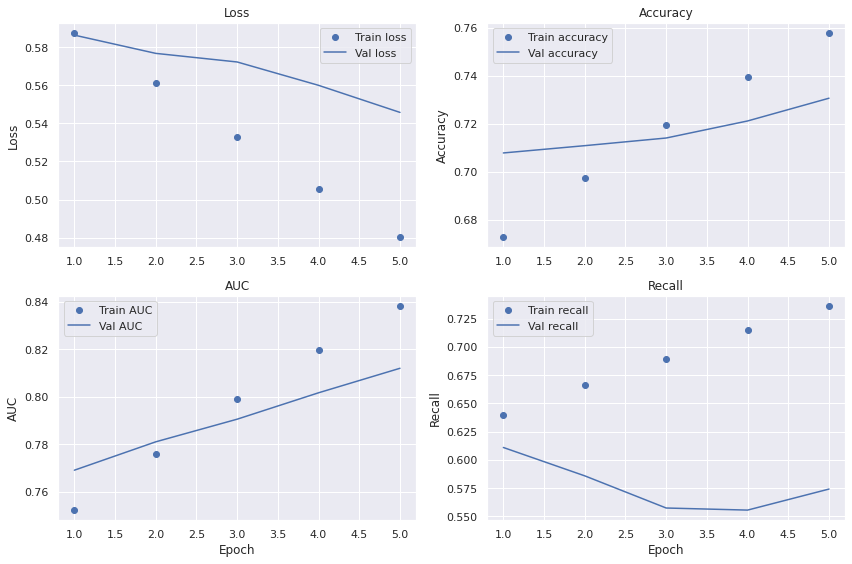

In [ ]:
# Plot loss, accuracy, AUC and recall on the train and validation sets
plot_history(history.history, soft=True)

<a name="evaluate_xception_metrics"></a>


### Evaluate metrics

Taking a look at the performance on the test set we note that it's roughly in par with previous models'. The major difference here though is higher precision, meaning that the model gets it right more frequently than before. There seem to have been a trade-off though; lower recall. 

In [ ]:
# Evaluate the model on the test set
xcep1_model = keras.models.load_model(model_dir+'Xception_1') # Load the best Xception model
test_results = xcep1_model.evaluate(test_generator)

21/21 [==============================] - 5s 184ms/step - loss: 0.4581 - recall: 0.7467 - auc: 0.8680 - precision: 0.7972 - accuracy: 0.7985 - tp: 224.0000 - fp: 57.0000 - tn: 303.0000 - fn: 76.0000


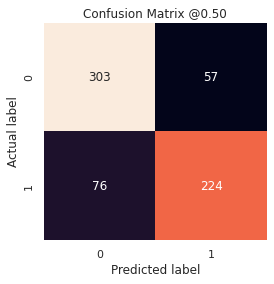


Malignant Tumors Detected          (True Positives): 224
Malignant Tumors Missed            (False Negatives): 76
Benign Tumors Detected             (True Negatives): 303
Benign Tumors Incorrectly Detected (False Positives): 57


In [ ]:
# Make predictions, get the labels and plot the resulting confusion matrix
test_preds_xcep1, test_labels = get_predictions_and_labels(xcep1_model, test_generator)
plot_cm(test_labels, test_preds_xcep1>0.5)

<br>

61 malignant tumors are missed by the model - a significant number and more than before. However, there are also considerable fewer incorrectly detected benign tumors (65). 


<a name="plot_roc_auprc_xception"></a>


### Plot the ROC and AUPRC

The ROC and AUPRC plots are displayed below and they confirm the high variance; a difference between the train set on one hand, and the validation and test sets on the other. 

In [ ]:
# Get predictions and labels for the train and validation sets
train_preds_xcep1, train_labels_xcep1 = get_predictions_and_labels(xcep1_model, train_generator_augmentation)
validation_preds_xcep1, validation_labels_xcep1 = get_predictions_and_labels(xcep1_model, validation_generator)

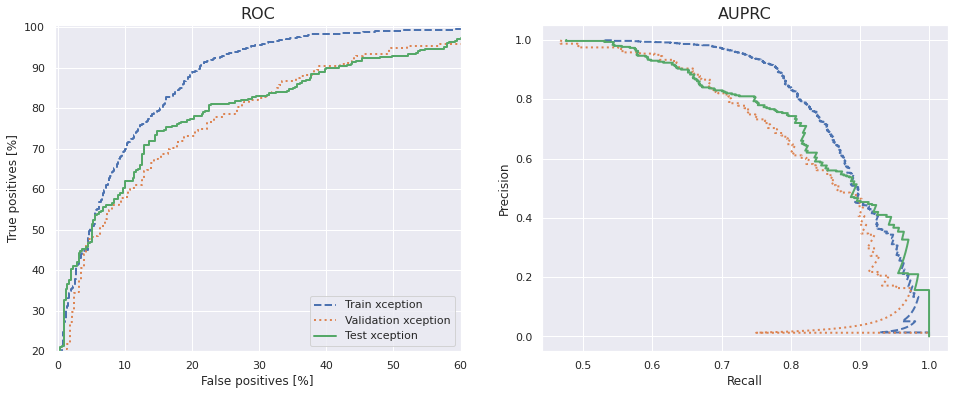

In [ ]:
# Plot the ROC and AUPRC
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train xception', train_labels_xcep1, train_preds_xcep1, linestyle='--')
plot_roc('Validation xception', validation_labels_xcep1, validation_preds_xcep1, linestyle=':')
plot_roc('Test xception', test_labels, test_preds_xcep1)

plt.subplot(1, 2, 2)
plot_prc('Train xception', train_labels_xcep1, train_preds_xcep1, linestyle='--')
plot_prc('Validation xception', validation_labels_xcep1, validation_preds_xcep1, linestyle=':')
plot_prc('Test xception', test_labels, test_preds_xcep1);


<a name="evaluate_multiple_xception"></a>


### Train and evaluate multiple Xception models


Instantiate, train and evaluate multiple pre-trained Xception models. 

In [ ]:
def train_and_evaluate_pretrained_Xception(n_times, train_gen, valid_gen, test_gen, 
                                           name, epochs=20, output_bias=None):
    """ Function for training and evaluating pre-trained Xception models over several runs 
        for a better estimaton of the model's performance. Returns scores on the test and validation 
        sets as well as the test set. 

    Parameters
    ----------

    n_times: int
      Number of models to train and evaluate. Higher values takes longer but yield 
      more confident estimations.

    train_gen: generator, Numpy array, DataFrame
      Train set.

    valid_gen: generator, Numpy array, DataFrame
      Validation set.

    test_gen: generator, Numpy array, DataFrame
      Test set.

    name: str
      Name to store models and scores under.

    epochs: int
      Number of epochs to train each model for.

    output_bias: tensorflow constant
      Initial bias in the output Dense layer of the classifier. Specify this for faster convergence. 

    """


    histories = []                # Train and validation scores
    test_scores = []              # Test scores

    for i in range(n_times):
        print(f"Training model: {i+1} (out of {n_times} times)...")
        start = time.time()

        # Instantiate the Xception convolutional base
        conv_base = keras.applications.Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(None, None, 3)
        )

        # Add a densely connected classifier on top of the convolutional base
        input_tensor = keras.Input(shape=image_size+(3,), name='input')
        x = conv_base(input_tensor)
        x = layers.Flatten()(x)
        x = Dense(16, activation='relu')(x)
        output = Dense(1, activation='sigmoid', name='output',
                      bias_initializer=output_bias)(x)

        model = keras.Model(inputs=input_tensor, outputs=output, name=name)

        # Don't train the convolutional base
        conv_base.trainable = False

        # Compile the model
        model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.Adam(lr=1e-5),
                      metrics=METRICS)

        # Train the model
        hist = model.fit(train_gen,
                         epochs=epochs,
                         callbacks=callbacks(name),
                         validation_data=valid_gen,
                         workers=2,
                         verbose=0,
                  )
        
        # Print out how long it took to train one model
        time_taken = time.gmtime(int(time.time() - start))
        print(f'Time taken: {time.strftime("%Hh %Mmin %Ss", time_taken)} ... Evaluating...')

        # Load the best model and evaluate it on the test set
        best_model = keras.models.load_model(model_dir+name)
        test_score = best_model.evaluate(test_gen, return_dict=True)
        
        # Store the results
        histories.append(hist.history)
        test_scores.append(test_score)

        # Clear memory by releasing the global state
        tf.keras.backend.clear_session()

    # Save histories and test scores to file
    pd.DataFrame(histories).to_csv(csv_dir+name+'_histories.csv', index=False)
    pd.DataFrame(test_scores).to_csv(csv_dir+name+'_scores.csv', index=False)

    return histories, test_scores

In [ ]:
%%time

# Train and evaluate 10 models
histories, test_scores = train_and_evaluate_pretrained_Xception(
    1,
    train_generator_augmentation, 
    validation_generator, 
    test_generator,
    name='Xception_1_cv',
    epochs=5,
    output_bias=output_bias,
)

Training model: 1 (out of 1 times)...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Time taken: 00h 04min 13s ... Evaluating...
21/21 [==============================] - 4s 138ms/step - loss: 0.4559 - recall: 0.7167 - auc: 0.8839 - precision: 0.8398 - accuracy: 0.8091 - tp: 215.0000 - fp: 41.0000 - tn: 319.0000 - fn: 85.0000
CPU times: user 6min 15s, sys: 11.9 s, total: 6min 27s
Wall time: 4min 26s


<a name="metrics_multiple_xception"></a>


### Evaluate metrics over multiple runs


Using a pre-trained Xception model do seem to decrease the standard deviation across most metrics. That's a good thing as we can feel better about the model's performance at any given moment. We can also confirm a higher precision compared with before, while maintaining roughly the same accuracy and AUC. The higher precision has been traded for lower recall though. Importantly, the model also takes longer to train and more disc space than previous models (around 100MB). 

In [ ]:
print_model_performance(pd.DataFrame(test_scores))

Average model performance on the test set over 1 runs:

Loss:      0.46  (±0.00)
Recall:    0.72  (±0.00)
Auc:       0.88  (±0.00)
Precision: 0.84  (±0.00)
Accuracy:  0.81  (±0.00)
Tp:        215.0 (±0.00)
Fp:        41.0  (±0.00)
Tn:        319.0 (±0.00)
Fn:        85.0  (±0.00)


<a name="fine_tune_xception"></a>


# Fine-tune the Xception model

It's often fruitful to fine-tune pre-trained models. However, as stated earlier, it's necessary to freeze the *Xception* convolutional base in order to be able to train the classifier on top. For the same reason, **it's only possible to fine-tune the top layers of the convolutional base once the classifier on top has already been trained**. If the classifier isn't already trained, the error signal propagating through the network during training will be so large that the previously learned weights will be destroyed. Moving forward, the steps for fine-tuning a pre-trained network are:

- Add a custom network on top of an already-trained network.
- Freeze the already-trained base network.
- Train the added custom network.
- Unfreeze some of the top layers in the base network.
- Jointly train both these layers and the added custom network.


We have already implemented the first three steps. Let's move forward with unfreezing some of the last layers in the Xception convolutional base. Remember that the first layers learn more generic features while the later ones learn more specific to the task. The initial weights have been trained on Imagenet; a dataset with a lot of pictures on animals, nature and humans - which are quite different from cancer tumors. Transfer learning has proven successful across very diverse datasets, but in order to increase the probability of learning more tumor relevant features in the last few layers, I will unfreeze a larger chunk. In this particular case I choose to unfreeze all layers in *block14*; a total of 6 layers. Experimenting with unfreezing more blocks might be a good idea though. 



<a name="trainable_layers"></a>

### Specify trainable layers


All layers in *block14* will be unfreezed.

In [ ]:
# Start by setting all layers as trainable
conv_base.trainable = True

# Freeze the layers belonging to "block14"
set_trainable = False
for layer in conv_base.layers:
    if 'block14_sep' in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Check how the model looks like now
model.summary()

Model: "Xception_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 16)                1605648   
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 22,467,145
Trainable params: 6,354,465
Non-trainable params: 16,112,680
_________________________________________________________________


By unfreezing the last 6 layers we have increased the number of trainable parameters from 1.6 million to around 6.4 million. 


<a name="fine_tune_xception"></a>


### Train the model

Train the model with a very low learning rate to not risk destroying the weights already learned by the network. 

In [ ]:
%%time

# Compile the model and make sure there a fewer trainable parameters now
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(lr=2e-6), # Lower learning rate
              metrics=METRICS)

# Train the model
history = model.fit(train_generator_augmentation,
                    epochs=5,
                    callbacks=callbacks('Xception_1_tuned'),
                    validation_data=validation_generator,
                    workers=2)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
66/66 [==============================] - 57s 793ms/step - loss: 0.4342 - recall: 0.7871 - auc: 0.8955 - precision: 0.8010 - accuracy: 0.8182 - tp: 1087.0000 - fp: 270.0000 - tn: 1451.0000 - fn: 294.0000 - val_loss: 0.5407 - val_recall: 0.4644 - val_auc: 0.8512 - val_precision: 0.8952 - val_accuracy: 0.7324 - val_tp: 111.0000 - val_fp: 13.0000 - val_tn: 275.0000 - val_fn: 128.0000
Epoch 2/5
66/66 [==============================] - 31s 462ms/step - loss: 0.4188 - recall: 0.8006 - auc: 0.9066 - precision: 0.8292 - accuracy: 0.8346 - tp: 767.0000 - fp: 158.0000 - tn: 994.0000 - fn: 191.0000 - val_loss: 0.5353 - val_recall: 0.4937 - val_auc: 0.8423 - val_precision: 0.8872 - val_accuracy: 0.7419 - val_tp: 118.0000 - val_fp: 15.0000 - val_tn: 273.0000 - val_fn: 121.0000
Epoch 3/5
66/66 [==============================] - 31s 454ms/step - loss: 0.4276 - recall: 0.8121 - auc: 0.8973 - precision: 0.8268 - accuracy: 0.8374 - tp: 778.0000 - fp: 163.0000 - tn: 989.0000 - fn: 180.0000 - val

<a name="tuned_xception_history"></a>


### Check training history

Validation AUC stops improving after only 26 epochs and training terminates.

The curves display similar characteristics as before with significant variance and fairly low bias. It's unclear whether fine-tuning has improved the performance by only looking at these plots though. 

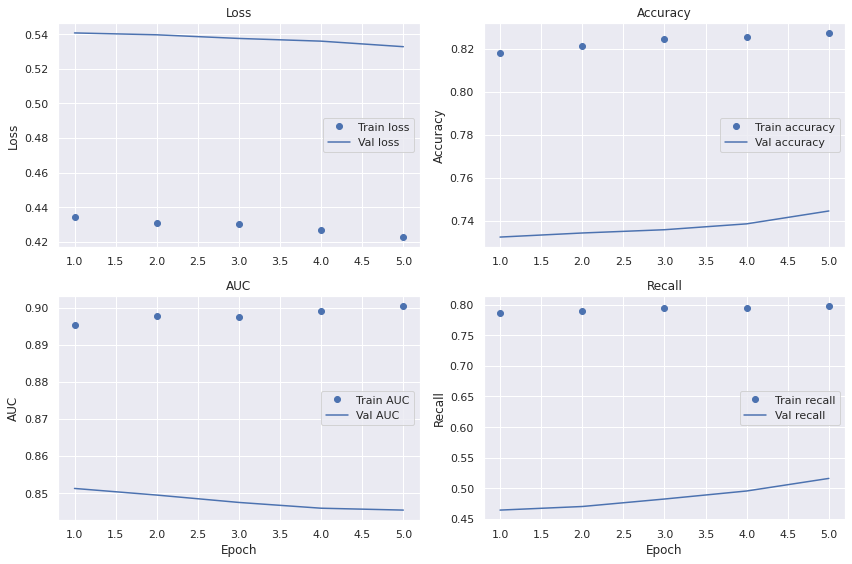

In [ ]:
# Plot loss, accuracy, AUC and recall on the train and validation sets
plot_history(history.history, soft=True)

<a name="metrics_tuned_xception"></a>


### Evaluate metrics

In [ ]:
# Evaluate the model on the test set
xcep1_tuned = keras.models.load_model(model_dir+'Xception_1_tuned') # Load the best augmented model
test_results = xcep1_tuned.evaluate(test_generator)

21/21 [==============================] - 4s 140ms/step - loss: 0.4915 - recall: 0.5367 - auc: 0.8686 - precision: 0.8703 - accuracy: 0.7530 - tp: 161.0000 - fp: 24.0000 - tn: 336.0000 - fn: 139.0000


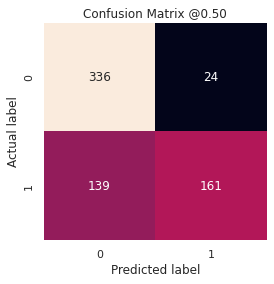


Malignant Tumors Detected          (True Positives): 161
Malignant Tumors Missed            (False Negatives): 139
Benign Tumors Detected             (True Negatives): 336
Benign Tumors Incorrectly Detected (False Positives): 24


In [ ]:
# Make predictions, get the labels and plot the resulting confusion matrix
test_preds_xtuned, test_labels = get_predictions_and_labels(xcep1_tuned, test_generator)
plot_cm(test_labels, test_preds_xtuned>0.5)

<br>

There's little difference between the fine-tuned Xception model and the previous version where we only trained the custom classifier on top. In some cases we can expect a few percent of improvement though. The small differences even indicate that fine-tuning decreased model performance slightly. But again, this might be explained by random initiation during training and data loading and should rather be more thoroughly investigated by running multiple models and averaging their results. But that is very computational expensive and is left for future work.  


<a name="tuned_roc_auprc"></a>


### Plot the ROC and AUPRC

In [ ]:
# Get predictions and labels for the train and validation sets
train_preds_xtuned, train_labels_xtuned = get_predictions_and_labels(xcep1_tuned, train_generator_augmentation)
validation_preds_xtuned, validation_labels_xtuned = get_predictions_and_labels(xcep1_tuned, validation_generator)

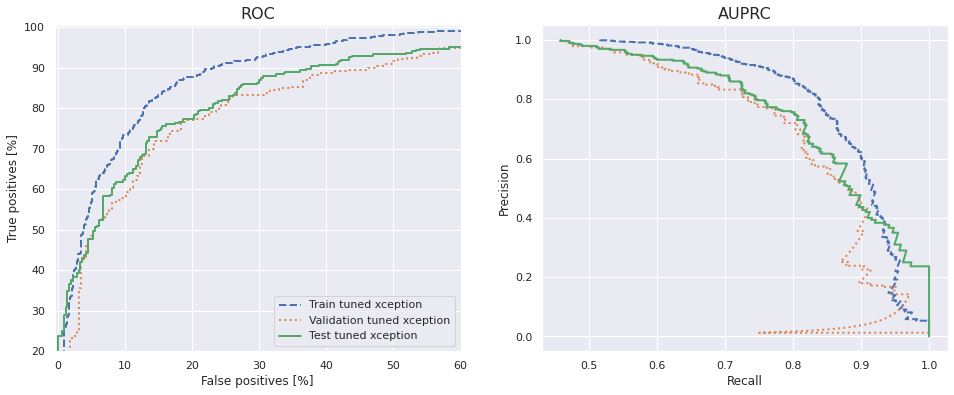

In [ ]:
# Plot the ROC curve
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plot_roc('Train tuned xception', train_labels_xtuned, train_preds_xtuned, linestyle='--')
plot_roc('Validation tuned xception', validation_labels_xtuned, validation_preds_xtuned, linestyle=':')
plot_roc('Test tuned xception', test_labels, test_preds_xtuned)

plt.subplot(1, 2, 2)
plot_prc('Train tuned xception', train_labels_xtuned, train_preds_xtuned, linestyle='--')
plot_prc('Validation tuned xception', validation_labels_xtuned, validation_preds_xtuned, linestyle=':')
plot_prc('Test tuned xception', test_labels, test_preds_xtuned);

<br>

The ROC and AUPRC curves confirm high variance also for the fine-tuned model. 


<a name="summary"></a>


# Summary


The plots below display the average loss, recall, AUC, precision and accuracy for the baseline, baseline with data augmentation and Xception with data augmentation over 10 runs on the test set. By only looking at the plots below it's not clear which model performs well. There are tradeoffs where higher recall and lower precision (the both baselines) are traded for lower recall but higher precision (Xception). All three models display similar AUC and accuracy. Adding data augmentation significantly decreases the standard deviation across all metrics and lead to more stable models.

In order to get a more holistic view of the models' performance, we should compare the metrics on the train and validation sets as well. As for the [baseline](#baseline_history) and [augmented baseline](#check_aug_history) the models reach their maximum learning capacity early on - meaning that there is little room for improvement even though we would add more data. However, the [Xception](#check_xception_history) model keeps improving on the training set even after the validation metrics have stagnated. The resulting high variance can often be treated by adding more data to the model with a resulting boost in performance. 

Thus, if we are limited to current data, it might be better to go with the data augmented baseline as its performance is comparable to the larger Xception model but is faster to train, takes less space on disk and is in general [less complex](https://en.wikipedia.org/wiki/KISS_principle). It's also more reliable than the baseline without augmented data. However, if there is a way to collect more data, the Xception model will likely do significantly better across most, if not all, metrics. 

We can conclude that it is possible to classify malignant from benign skin cancer using deep learning. Future work should start by collecting more data as it will likely yield the largest improvements. 

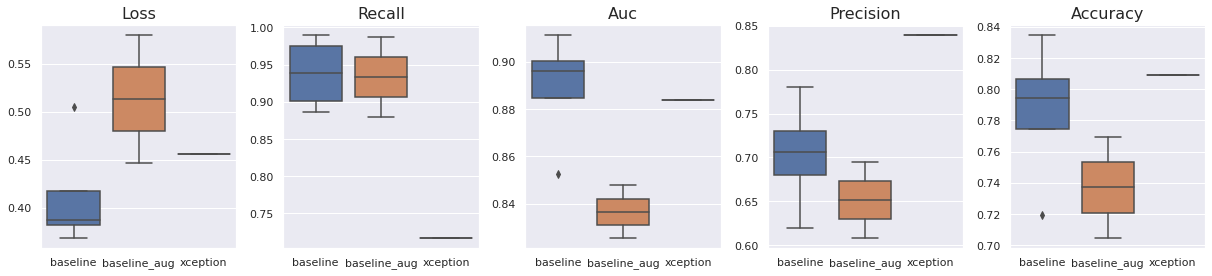

In [ ]:
# Load the model scores
baseline = pd.read_csv(csv_dir+'base_model_cv_scores.csv')
baseline_augmented = pd.read_csv(csv_dir+'base_model_augmented_cv_scores.csv')
xception = pd.read_csv(csv_dir+'Xception_1_cv_scores.csv')

# Define a function for extracting a metric from all three dataframes
def extract_metric(metric):
    result = pd.DataFrame({'baseline': baseline[metric],
                           'baseline_aug': baseline_augmented[metric],
                           'xception': xception[metric]})
    return result


# Display Loss Recall, AUC, Precision and Accuracy for each of the models
metrics_list = ['loss', 'recall', 'auc', 'precision', 'accuracy']
plt.figure(figsize=(17, 4))

for i, name in enumerate(metrics_list):
    plt.subplot(1, 5, i+1)
    sns.boxplot(data=extract_metric(name))
    plt.title(name.capitalize(), fontsize=16)
plt.tight_layout()